# Surface tension calculations using DFT for Helium-Deuterium mixtures
Classical density functional theory for interfacial properties of hydrogen, helium, deuterium, neon and their mixtures ([doi:10.1063/5.0137226](https://doi.org/10.1063/5.0137226))

In [1]:
from feos import *
from feos.si import *
from feos.dft import *
from feos.saftvrqmie import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
import json
from scipy.optimize import fsolve

sns.set_context('talk')
sns.set_palette('Dark2')
sns.set_style('ticks')

# Set up FEOS functional

In [2]:
parameters = SaftVRQMieParameters.from_json(["helium", "deuterium"], 
                                            "../../parameters/saftvrqmie/hammer2023.json", 
                                            binary_path="../../parameters/saftvrqmie/aasen2020_binary.json")
eos = HelmholtzEnergyFunctional.saftvrqmie(parameters)

## Critcal temperature estimate

In [3]:
tc_deuterium = 38.34
cp = State.critical_point(eos, np.array([0.5, 0.5]) * MOL, initial_temperature=35*KELVIN)

# Utility functions

In [4]:
def density_error(x_he, T, eos, rho_he_spec):
    """Evaluate relative error in partial density for helium"""
    x = np.array([x_he[0]/1000, 1-x_he[0]/1000])
    vle_guess = PhaseEquilibrium.bubble_point(eos, T * KELVIN, x)
    rho_he = vle_guess.vapor.partial_density[0] / MOL * METER**3
    error = (rho_he_spec - rho_he)/rho_he_spec
    return error

def surftens_mulero2012(fluid, tr):
    """
    Calculate pure fluid surface tension using Mulero et al. 2012 correlation (doi:10.1063/1.4768782)
    Args:
        fluid (str): Component name
        tr (np.ndarray): Reduced temperature
    Returns:
        sigma (np.ndarray): Surface tension (mN/m)
    """
    ff = open("mulero_2012_parameters.json", "r")
    complist = json.load(ff)
    ff.close()
    sigma = np.zeros_like(tr)
    for i in range(len(complist[fluid]["sigma"])):
        sigma[:] += complist[fluid]["sigma"][i] * \
            (1-tr[:])**complist[fluid]["n"][i]
    return sigma * NEWTON / METER / (MILLI * NEWTON/  METER)

# Load experimental data and set some constants
Paine and Seidel.
*The adsorption of helium on liquid hydrogen.*
Phys. B: Condens. Matter, 1994.

In [5]:
data = np.loadtxt("./data/deuterium_helium_exp_data.dat", skiprows=1)
NA = 6.02214857E+23
Temperatures = np.unique(data[:, 0])

# Polynomial $x_\rm{He}(\rho_\rm{He}) \times 1000$ along Pxy curve

In [6]:
polynomialfit = {}
polynomialfit["20"] = np.poly1d([2.77511195e-13, -1.62794362e-08, 1.04061440e-03, 3.55749085e-03])
polynomialfit["21"] = np.poly1d([3.11050375e-13, -1.78452507e-08, 1.25231735e-03, 3.42794882e-03])
polynomialfit["22"] = np.poly1d([3.41745522e-13, -1.91263957e-08, 1.49186801e-03, 3.41256793e-03])
polynomialfit["23"] = np.poly1d([3.80433522e-13, -2.02545613e-08, 1.76336232e-03, 3.12420795e-03])
polynomialfit["24"] = np.poly1d([4.18253168e-13, -2.08976527e-08, 2.06946383e-03, 2.97772280e-03])
polynomialfit["26"] = np.poly1d([5.19526320e-13, -2.04475681e-08, 2.80633414e-03, 2.62607082e-03])

# Find helium vapor composition, $x_{\rm{max}}$, given $\rho_{\rm{He}} (x_{\rm{max}})$ = $\rho_{\rm{max}}$

In [7]:
rho_max = 12000.0
x_max = []
x_he_fun_of_rho = {}
for T in tqdm.tqdm(Temperatures):
    x0 = polynomialfit[str(int(T))](rho_max)
    # Solve for rho_he(x) = rho_max
    x = fsolve(density_error, x0, args=(T, eos, rho_max))
    x_max.append(x[0]/1000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.14s/it]


# Map isotherms to $x_{\rm{He}}=x_{\rm{max}}$

In [8]:
states = []
for i, T in enumerate(tqdm.tqdm(Temperatures)):
    xa = np.linspace(1.0e-8, x_max[i], 20)
    T_states = []
    for x in xa:
        x_sol = np.array([x, 1-x])
        state = PhaseEquilibrium.bubble_point(eos, T * KELVIN, x_sol)
        T_states.append(state)
    states.append(T_states)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.03s/it]


# Calculate and plot surface tension along the isotherms

In [9]:
gamma = []
for T_states in tqdm.tqdm(states):
    gamma_T = []
    for state in T_states:
        gamma_T.append(PlanarInterface.from_tanh(state, 1024, 200 * ANGSTROM, cp.temperature).solve().surface_tension / (MILLI  * NEWTON / METER))
    gamma.append(gamma_T)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:21<00:00, 33.63s/it]


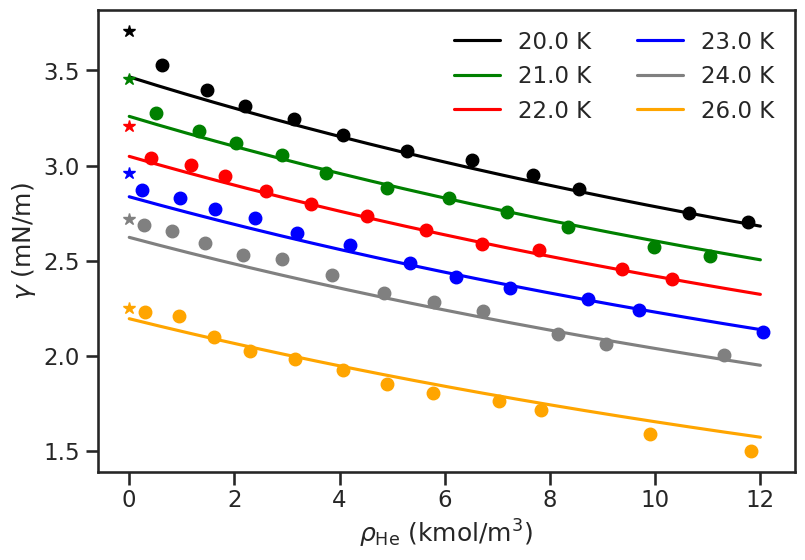

In [10]:
plt.figure(figsize=(9, 6))
colors = ["k","g","r","b","grey","orange","cyan"]
for i, T in enumerate(Temperatures):
    rho = []
    for state in states[i]:
        rho.append(state.vapor.partial_density[0] / MOL * METER**3)
    plt.plot(np.array(rho)/1000, gamma[i], label=f"{T:.1f} K", color=colors[i])
    rho_exp = data[np.isclose(data[:, 0], T, atol=0.001),1] * 1e27 / NA
    sur_tens_exp = data[np.isclose(data[:, 0], T, atol=0.001),2]
    plt.plot(rho_exp/1000, sur_tens_exp, linestyle="None", marker="o", color=colors[i])
    tr = np.array([T/tc_deuterium])
    s_nist = surftens_mulero2012("deuterium", tr)
    plt.plot([0.0], s_nist, "*", color=colors[i])    

plt.xlabel(r'$\rho_{\rm{He}}$ (kmol/m$^3$)')
plt.ylabel(r'$\gamma$ (mN/m)')
leg = plt.legend(loc='best', ncol=2, frameon=False)

# Calculate composition given partial helium density of each experimental point

In [11]:
exp_states = []
for T in tqdm.tqdm(Temperatures):
    # Loop all experiments on current temperature
    data_T = data[np.isclose(data[:,0],T),1:3]
    for j in range(np.shape(data_T)[0]):
        rho_he_j = data_T[j,0] * 1e27 / NA
        surftens_exp = data_T[j,1]
        # Interpolate to get initial guess, x0: rho_he(x0) ~= rho_he_j
        x0 = polynomialfit[str(int(T))](rho_he_j)
        # Solve for rho_he(x) = rho_he_j
        x = fsolve(density_error, x0, args=(T, eos, rho_he_j))
        exp_states.append([x[0]/1000, surftens_exp, T])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:09<00:00, 11.54s/it]


# Calculate state and surface tension for the experimental points

In [12]:
states = []
for x, s_exp, T in tqdm.tqdm(exp_states):
    x_sol = np.array([x, 1-x])
    state = PhaseEquilibrium.bubble_point(eos, T * KELVIN, x_sol)
    states.append([state, s_exp, T])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:08<00:00,  8.54it/s]


In [13]:
sft = []
for state, s_exp, T in tqdm.tqdm(states):
    sft.append({
        "dft": PlanarInterface.from_tanh(state, 1024, 200 * ANGSTROM, cp.temperature).solve().surface_tension / (MILLI  * NEWTON / METER), 
        "exp": s_exp,
        "T": T}
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [01:47<00:00,  1.55s/it]


# Calculate mean absolute deviation (MAD)

In [14]:
df = pd.DataFrame(sft)
mad = 100*np.sum(np.abs((df.dft-df.exp)/df.exp))/df.exp.shape[0]
print(f"MAD={mad:.1f} %")

MAD=1.3 %


# Plot error map

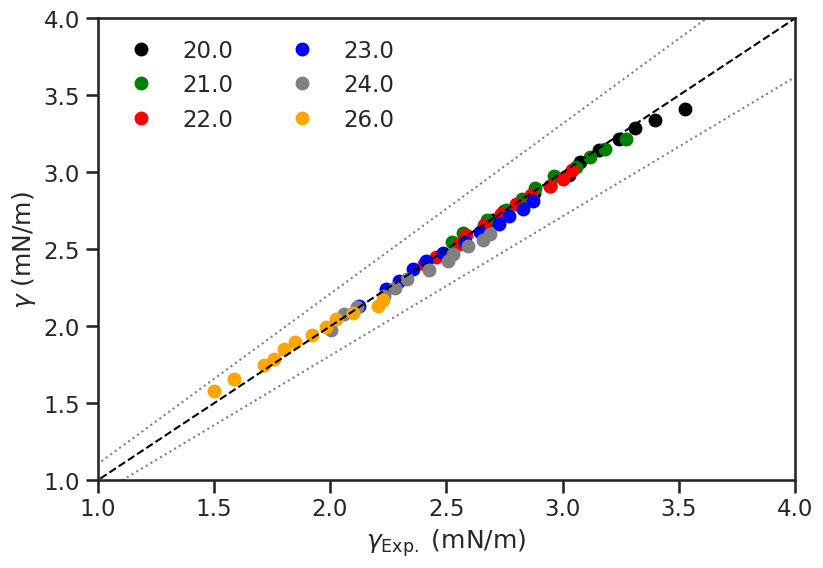

In [15]:
plt.figure(figsize=(9, 6))
smax = 4
err_fan = 0.1
groups = df.groupby('T')
for i, res in enumerate(groups):
    name=res[0]
    group=res[1]
    plt.plot(group.exp, group.dft, "o", color=colors[i], label=str(name))
plt.plot([0, smax], [0, smax], color="black", linestyle="dashed", alpha=1.0, lw=1.5)
plt.plot([0, smax*(1+err_fan/2)], [0, smax*(1-err_fan/2)], color="black", linestyle="dotted", alpha=0.5, lw=1.5)
plt.plot([0, smax*(1-err_fan/2)], [0, smax*(1+err_fan/2)], color="black", linestyle="dotted", alpha=0.5, lw=1.5)
plt.ylabel(r'$\gamma$ (mN/m)')
plt.xlabel(r'$\gamma_{\rm{Exp.}}$ (mN/m)')
plt.xlim(1, smax)
plt.ylim(1, smax)
leg = plt.legend(loc='best', ncol=2, frameon=False)